# Analysis Challenge Assignment
**Author**: Nicolas Dussaillant

**Date**: 11/30/2021

**Course**: HUDK 4050 Core Methods in Educational Data Mining

## 1. Presentation

For this challenge I will conduct a social network analysis for a 9th grade class of girls. In 2018 I was the head teacher of this class and also their math teacher. I want to analize the impact of the social network created between the students of the class on their final math grades.

The final goal is to seek for interpretations of their math performance based on their social interactions, check if popular girls do better or worse in maths than the more isolated ones, if central girls in the network show different assessments than border girls, and if there exist a similar performance inside each group of the class.

Several deeper analyses can be conducted and it'd be very interesting to go further on this topic. However, due to data collection restrictions and time limit, this work limits its potential to the extent of this document. Further analysis with more variables, more reliable data, and more recent observations can be conducted. The data come direct from my past files and personal observations, comparison with the students' self observations might be very useful, but for this time that data gathering was not possible.

## 2. Proposal

This work is based on the following assumptions, methods, procedures, context and goals.

### 2.1 Data collection

The data come from the stored math grades that I had stored in my files from when I was a highschool math teacher. The social interactions are determined by my own observations of the relationships that existed in my class while I was their head teacher (I used to spend more than 8 hours a week inside the classroom with them and some more time outside of the classroom when they needed my assistance or I needed to mediate conflicts). The identity of each girl is protected because the data only contain their first name and the initial of their last name.

According to the aforementioned situation the data collected are the following:
1. ID: First name + Last name initial
2. Math grade: Final grade in their mathematics class measured in a scale from 2.0 to 7.0, where 4.0 is the approval grade.
3. Social interactions: Bond between students based on their head teacher's observation for that year. A strong bond is represented with a 1, a moderate bond 0.5, and a small or non-existing bond with a 0.

This information is available in the following files:

[Math grades](https://drive.google.com/file/d/1iC9vC0gJvQqeaGMqiGeiVspf0tD0eTlM/view?usp=sharing)

[Social interactions](https://drive.google.com/file/d/1ftUx0q7y6u8Ig--sqSPi_D0NnOTU50Mz/view?usp=sharing)


### 2.2 Context

The data come from a 9th grade class of girls. The class had more than 35 students, however, the number of students that finished that year were 28, consequently the students analized are those 28 girls.

The school is called Colegio Santa Teresa de Jesus de los Andes, it is located in Huechuraba, Santiago, Chile. The school is part of a neighborhood called La Pincoya that is known for its violence, and drug addiction and drug trafficking levels. Colegio Santa Teresa is a charter school part of the catholic movement Regnum Christi. Most of its students live near the school and come from low-income and disadvantaged families. The school is free for every student and delivers free lunch for them. Colegio Santa Teresa is a K-12 school with a technical formation in business administration for 11th and 12th grades, it has around 800 students, male and female.

### 2.3 Analysis

The following sections of this assignment analyze the social network characteristics of this class and seek for potential relationships with their grades in their math class. Parameters like density, degree centrality, closeness centrality, betweenness centrality, and community detection for the network and each students are analyzed in conjuction with math performance.

## 3. Procedure

### 3.1 Environment preparation

Import the necessary packages:

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

### 3.2 Data cleaning and preparation

Import the social network. The network is stored as a adjacency matrix and in this part is transformed into an edge list. Student1 and Student2 are the students between an interaction exists. The weight is the strength of that social bond observed by the teacher (0.5 or 1 if it exists).

In [2]:
# Read file of the class (IA)
IA = pd.read_csv('social_interaction.csv', index_col = 0)

# Transform the data into an edge list stored in a pandas DataFrame
IA.values[[np.arange(len(IA))]*2] = np.nan
edge_list = IA.stack().reset_index()
edge_list.set_axis(['student1', 'student2', 'weight'], axis = 1, inplace = True)
edge_list.drop_duplicates(inplace = True)
edge_list.drop(edge_list[edge_list.weight == 0.0].index, inplace = True)
display(edge_list)

/var/folders/lc/stkk_5mx3gq9ypk8pz7l_74w0000gn/T/ipykernel_4265/2231902425.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  IA.values[[np.arange(len(IA))]*2] = np.nan


,student1,student2,weight
2,Aylyne A,Margarita C,0.5
4,Aylyne A,Florencia C,1.0
5,Aylyne A,Blanca C,0.5
6,Aylyne A,Valentina C,0.5
9,Aylyne A,Arantxa G,1.0
...,...,...,...
766,Anubis C,Yanira G,0.5
767,Anubis C,Thiare G,1.0
768,Anubis C,Claudia J,0.5
773,Anubis C,Melanie R,0.5


Import the students' math grades:

In [3]:
math_grades = pd.read_csv('math_grades.csv')
display(math_grades)

,student,math_grade
0,Aylyne A,6.8
1,Yasmin A,4.7
2,Margarita C,5.9
3,Constanza C,5.5
4,Florencia C,6.3
5,Blanca C,5.6
6,Valentina C,5.0
7,Fernanda C,3.5
8,Thiare F,3.4
9,Arantxa G,5.8


### 3.3 Network representation

In this part we represent the social network to see the interactions inside the class. For this we plot the network using nodes for each student and thin lines for edges representing medium strength bonds and bold lines for edges representing large strength bonds.

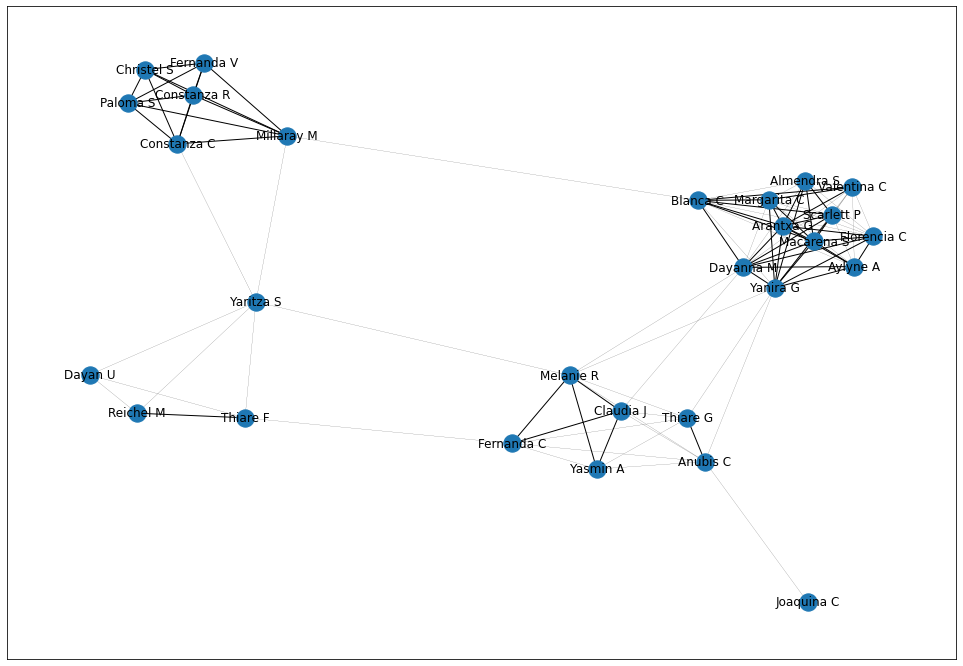

In [4]:
# Create the edge list in networkx
G = nx.from_pandas_edgelist(edge_list,
                           source = 'student1',
                           target = 'student2',
                           edge_attr = 'weight',
                           create_using = nx.Graph)

# Set seed to facilitate reproducibility when plotting the network
np.random.seed(30)
pos = nx.layout.spring_layout(G, k = 1, weight = 'weight', iterations = 2000, scale = 2)

# Define the weights to use them now and later in this work (for display purposes weights are powed to cube)
edges = G.edges()
weights = [G[u][v]['weight']**3 for u,v in edges]

# Plot the network
plt.rcParams['figure.figsize'] = [17, 12] # Enlarge figure
nx.draw_networkx(G, 
                 pos = pos, 
                 with_labels = True, 
                 width = weights)
plt.show()

### 3.4 Data descriptive results

First, we analize the density of the network

In [5]:
density = nx.density(G)
density

0.2671957671957672

The density is 0.267 which is not a high density and shows us that the network is not very connected. As we saw above, there are very different groups with just a few and weak connections between them.

For the next parts we will compute different measures for each node (i.e. student). Some of them consider the strength of the bond (0, 0.5 or 1) which is represented as the weight of each edge in the graph (those measures include the prefix weighted_), the others consider the bond as equal for every case.

In [6]:
#Calculate de weighted degree of connection for each node
degree = G.degree(weight='weight')

#Format the data
weighted_degree = pd.DataFrame(degree, columns = ['student', 'weighted_degree'])
weighted_degree

,student,weighted_degree
0,Aylyne A,7.0
1,Margarita C,7.5
2,Florencia C,7.5
3,Blanca C,8.5
4,Valentina C,6.5
5,Arantxa G,10.0
6,Yanira G,10.5
7,Dayanna M,9.5
8,Scarlett P,8.0
9,Macarena S,9.5


In [7]:
close = nx.closeness_centrality(G)
cl = pd.DataFrame.from_dict(close, orient = 'index').reset_index(level=0).set_axis(
                                                    ['student', 'closeness'], axis = 1)
display(cl)

,student,closeness
0,Aylyne A,0.450000
1,Margarita C,0.457627
2,Florencia C,0.457627
3,Blanca C,0.551020
4,Valentina C,0.457627
5,Arantxa G,0.457627
6,Yanira G,0.551020
7,Dayanna M,0.529412
8,Scarlett P,0.457627
9,Macarena S,0.457627


In [8]:
between = nx.betweenness_centrality(G)
bt = pd.DataFrame.from_dict(between, orient = 'index').reset_index(level=0).set_axis(
                                                    ['student', 'betweenness'], axis = 1)
display(bt)

,student,betweenness
0,Aylyne A,0.000000
1,Margarita C,0.000317
2,Florencia C,0.000317
3,Blanca C,0.214941
4,Valentina C,0.000317
5,Arantxa G,0.000317
6,Yanira G,0.173536
7,Dayanna M,0.096565
8,Scarlett P,0.000317
9,Macarena S,0.000317


Now we combine every measure with grades in one DataFrame for further analyses.

In [9]:
class_data = math_grades.merge(weighted_degree, how='inner', on='student')
class_data = class_data.merge(cl, how='inner', on='student')
class_data = class_data.merge(bt, how='inner', on='student')
display(class_data)

,student,math_grade,weighted_degree,closeness,betweenness
0,Aylyne A,6.8,7.0,0.450000,0.000000
1,Yasmin A,4.7,3.5,0.385714,0.000000
2,Margarita C,5.9,7.5,0.457627,0.000317
3,Constanza C,5.5,5.5,0.415385,0.055081
4,Florencia C,6.3,7.5,0.457627,0.000317
5,Blanca C,5.6,8.5,0.551020,0.214941
6,Valentina C,5.0,6.5,0.457627,0.000317
7,Fernanda C,3.5,4.0,0.402985,0.048196
8,Thiare F,3.4,2.5,0.364865,0.029915
9,Arantxa G,5.8,10.0,0.457627,0.000317


### 3.5 Community detection

Now we calculate the communities present in this class using the greedy modularity computation:

In [10]:
from networkx.algorithms.community.modularity_max import greedy_modularity_communities

c = list(greedy_modularity_communities(G))

print(len(c))

4


There are 4 very distinguishable communities. Those are:

In [11]:
community_0 = sorted(c[0])
community_1 = sorted(c[1])
community_2 = sorted(c[2])
community_3 = sorted(c[3])

print(community_0)
print(community_1)
print(community_2)
print(community_3)

['Almendra S', 'Arantxa G', 'Aylyne A', 'Blanca C', 'Dayanna M', 'Florencia C', 'Macarena S', 'Margarita C', 'Scarlett P', 'Valentina C', 'Yanira G']
['Anubis C', 'Claudia J', 'Fernanda C', 'Joaquina C', 'Melanie R', 'Thiare G', 'Yasmin A']
['Christel S', 'Constanza C', 'Constanza R', 'Fernanda V', 'Millaray M', 'Paloma S']
['Dayan U', 'Reichel M', 'Thiare F', 'Yaritza S']


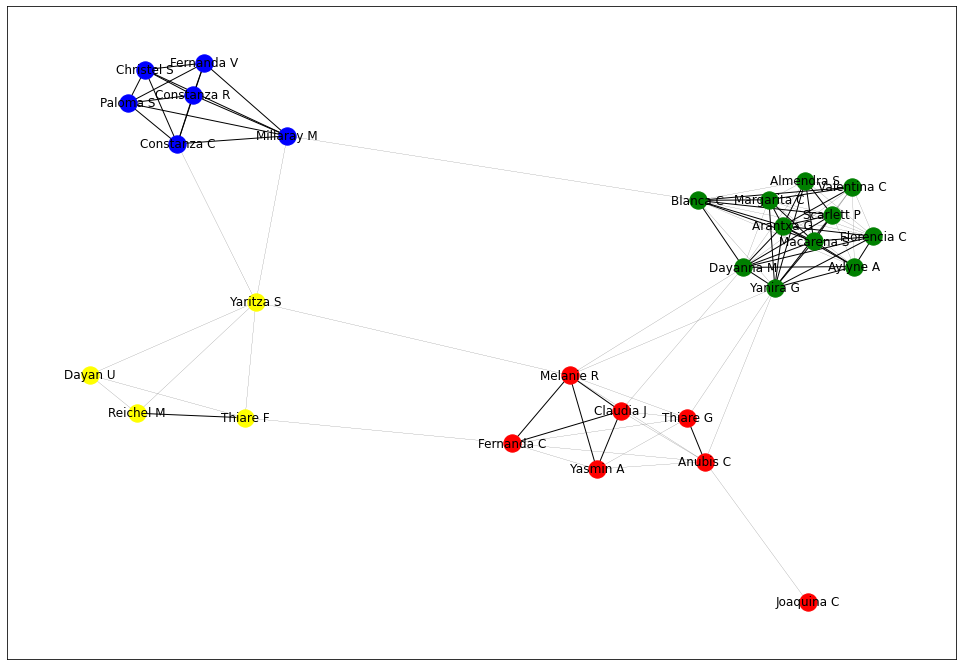

In [12]:
# Print out all the nodes with color
nx.draw_networkx_nodes(G, pos = pos, nodelist=community_0, node_color='green', label = True)
nx.draw_networkx_nodes(G, pos = pos, nodelist=community_1, node_color='red', label = True)
nx.draw_networkx_nodes(G, pos = pos, nodelist=community_2, node_color='blue', label = True)
nx.draw_networkx_nodes(G, pos = pos, nodelist=community_3, node_color='yellow', label = True)

# Print out the edges
nx.draw_networkx_edges(G, pos = pos, width = weights)

# Make sure the label is printed
nx.draw_networkx_labels(G, pos=pos)

# Show the plot so it supress the other networkx outputs
plt.show()

### 3.6 Data processing and results

Let's observe what happens between the math grades and the other variables. In the SNS pairplot we will analyze the first column.

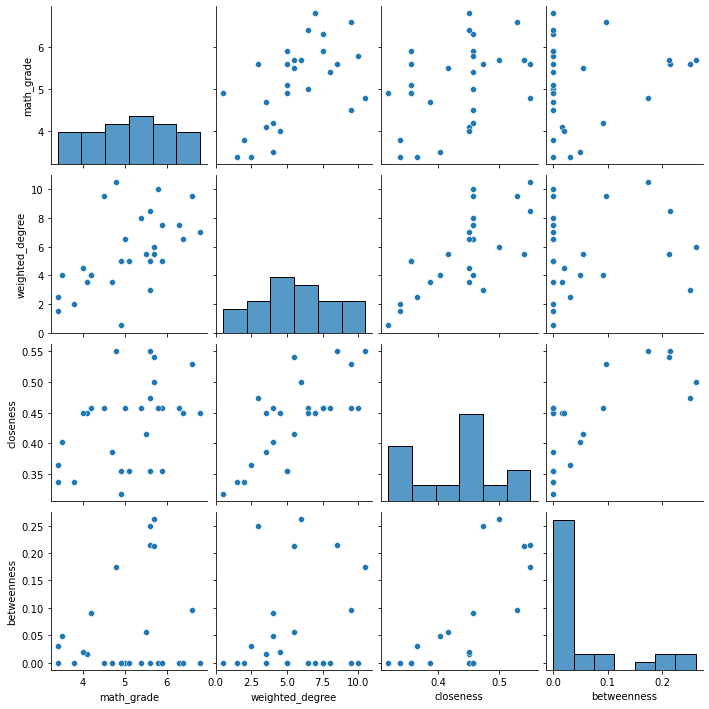

In [13]:
sns.pairplot(class_data)

The only one that shows some linear relation with the math grades could be the weighted degree which represents somehow the popularity of that girl. Let's check the linear regression for that case:

In [14]:
X = class_data['weighted_degree']
y = class_data['math_grade']
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:             math_grade   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     11.94
Date:                Tue, 30 Nov 2021   Prob (F-statistic):            0.00190
Time:                        23:52:30   Log-Likelihood:                -33.133
No. Observations:                  28   AIC:                             70.27
Df Residuals:                      26   BIC:                             72.93
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               3.9510      0.370     

/Users/ndussaillant/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


As we can see, the R-squared is 0.315, which is not a large effect for the relationship, but it is statistically significant (p < 0.01), so the popularity has some effect on their grades in this context.

The scatter plot with the regression is presented below:

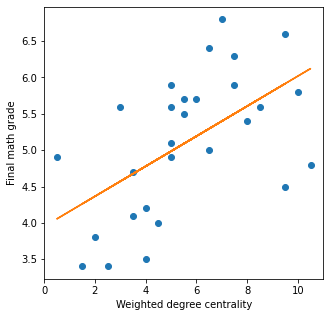

In [19]:
plt.rcParams['figure.figsize'] = [5, 5]
plt.plot(X, y, 'o')
pred_y = 3.9510 + 0.2068*X
plt.plot(X, pred_y)
plt.xlabel('Weighted degree centrality')
plt.ylabel('Final math grade')
plt.show()

Now let's analyze the communities. For that we will analyze the descriptive statistics of the math grades from each community.

In [16]:
com0 = math_grades[math_grades.student.isin(community_0)].describe(percentiles = [])
com1 = math_grades[math_grades.student.isin(community_1)].describe(percentiles = [])
com2 = math_grades[math_grades.student.isin(community_2)].describe(percentiles = [])
com3 = math_grades[math_grades.student.isin(community_3)].describe(percentiles = [])
#com_describe = pd.DataFrame([com0, com1, com2, com3])
com_describe = pd.concat([com0, com1, com2, com3], axis=1).set_axis(['Com0', 'Com1', 'Com2', 'Com3'], axis = 1)

display(com_describe)

,Com0,Com1,Com2,Com3
count,11.000000,7.000000,6.000000,4.000000
mean,5.736364,4.442857,5.450000,4.050000
std,0.757988,0.720780,0.378153,1.050397
min,4.500000,3.500000,4.900000,3.400000
50%,5.800000,4.200000,5.550000,3.600000
max,6.800000,5.700000,5.900000,5.600000


Clearly community 0 and community 2 have the highest mean math grades. If we see the network, those communities are the blue and green ones, which from a quick inspection we can see that are the most dense communitites with the strongest bonds inside them. Belonging to one of those communities apparently has a positive effect in their math grades. Also, community 2 has the lowest standard deviation, which means that students in that community have very similar math grades.

## 4. Conclusion and further developments

### 4.1 Conclusions

After this analysis we can conclude that popularity, measured as the weighted degree of centrality in the network, inside the class had a small positive effect of approximately 32% ($R^2$) on the grades of each student, that was statistically significant ($p$ < 0.01).

Also communities, especially the ones with the strongest bonds, have some sort of effect on their members' grades.

### 4.2 Deeper analyses

Deeper and new analyses can be conducted using the data and previous analyses from this study. It might be useful to analyze network centrality inside each community, evaluate betweenness centrality considering the strength of each bond, and also study the linear regressions for each community. Multiple regressions, interactions between degree and community belonging, and non-linear regressions can also be considered.

### 4.3 Furhter developments

Since this work was based on the head teacher's observations, it would be interesting to compare these observations with real social interactions observed by the students themselves. Other variables such as attendance, other subjects grades, and time since their enrollment in this school might be examined in other to improve the conclusions and actions that could be derived from studies like this.

Many actions may be taken using the results of these kinds of analysis, such as strengthening the bonds inside the class between some specific and strategic students.